Dataset link: https://www.kaggle.com/datasets/unanimad/the-oscar-award/

In [209]:
#imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from SPARQLWrapper import SPARQLWrapper, JSON

import json


sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [188]:
#read tsv file and add headers
movie_metadata_df = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])

#changing the values of outliers
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Zero Tolerance', 'movie_runtime'] = 88
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Hunting Season', 'movie_release_date'] = '2010-12-02'


#change movie_release_date to pandas datetime
movie_metadata_df['movie_release_date'] = pd.to_datetime(movie_metadata_df['movie_release_date'], format='%Y-%m-%d', errors='coerce')

#add realase_year
movie_metadata_df['startYear']= movie_metadata_df['movie_release_date'].dt.year

movie_metadata_df.head(10)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0
2,28463795,/m/0crgdbh,Brun bitter,NaT,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,NaT,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",NaN
4,261236,/m/01mrr1,A Woman in Flames,NaT,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",NaN
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913.0
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,NaT,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",NaN
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938.0
8,9997961,/m/06_y2j7,Contigo y aquí,NaT,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",NaN
9,2345652,/m/075f66,City of the Dead,NaT,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",NaN


In [189]:
#read text file and add headers
character_metadata_df = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id',
                        'freebase_movie_id',
                        'movie_release_date',
                        'character_name',
                        'actor_date_of_birth',
                        'actor_gender',
                        'actor_height',
                        'actor_ethnicity',
                        'actor_name',
                        'actor_age_at_movie_release',
                        'freebase_character_actor_map_id',
                        'freebase_character_id',
                        'freebase_actor_id'])

#change movie_release_date to pandas datetime
character_metadata_df['movie_release_date'] = pd.to_datetime(character_metadata_df['movie_release_date'], format='%Y-%m-%d', errors='coerce')

#add realase_year
character_metadata_df['movie_release_year']= character_metadata_df['movie_release_date'].dt.year

# add the movie name to the character metadata
character_metadata_df = pd.merge(character_metadata_df, movie_metadata_df[['wiki_movie_id', 'movie_name']], on='wiki_movie_id', how='left')

character_metadata_df.head(10)

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,movie_release_year,movie_name
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,Ghosts of Mars
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,Ghosts of Mars
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,Ghosts of Mars
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0,Ghosts of Mars
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0,Ghosts of Mars
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,2001.0,Ghosts of Mars
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m,2001.0,Ghosts of Mars
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7,2001.0,Ghosts of Mars
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0,2001.0,Ghosts of Mars
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy,2001.0,Ghosts of Mars


In [190]:
#read csv file data/the_oscar_award.csv
oscar_award_df = pd.read_csv('data/the_oscar_award.csv')
oscar_award_df = oscar_award_df[oscar_award_df['winner'] == True]
oscar_award_df = oscar_award_df.drop(columns=['winner'])
oscar_award_df.head(10)

,year_film,year_ceremony,ceremony,category,name,film
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven
6,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;
9,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise
10,1927,1928,1,CINEMATOGRAPHY,Karl Struss,Sunrise
11,1927,1928,1,DIRECTING (Comedy Picture),Lewis Milestone,Two Arabian Knights
13,1927,1928,1,DIRECTING (Dramatic Picture),Frank Borzage,7th Heaven
17,1927,1928,1,ENGINEERING EFFECTS,Roy Pomeroy,Wings
21,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,Wings
22,1927,1928,1,UNIQUE AND ARTISTIC PICTURE,Fox,Sunrise


In [191]:
# get the unique categories of the award
oscar_award_categories = oscar_award_df['category'].unique()
oscar_award_categories.sort()
oscar_award_categories

array(['ACTOR', 'ACTOR IN A LEADING ROLE', 'ACTOR IN A SUPPORTING ROLE',
       'ACTRESS', 'ACTRESS IN A LEADING ROLE',
       'ACTRESS IN A SUPPORTING ROLE', 'ANIMATED FEATURE FILM',
       'ART DIRECTION', 'ART DIRECTION (Black-and-White)',
       'ART DIRECTION (Color)', 'ASSISTANT DIRECTOR',
       'AWARD OF COMMENDATION', 'BEST MOTION PICTURE', 'BEST PICTURE',
       'CINEMATOGRAPHY', 'CINEMATOGRAPHY (Black-and-White)',
       'CINEMATOGRAPHY (Color)', 'COSTUME DESIGN',
       'COSTUME DESIGN (Black-and-White)', 'COSTUME DESIGN (Color)',
       'DANCE DIRECTION', 'DIRECTING', 'DIRECTING (Comedy Picture)',
       'DIRECTING (Dramatic Picture)', 'DOCUMENTARY',
       'DOCUMENTARY (Feature)', 'DOCUMENTARY (Short Subject)',
       'DOCUMENTARY FEATURE FILM', 'DOCUMENTARY SHORT FILM',
       'ENGINEERING EFFECTS', 'FILM EDITING', 'FOREIGN LANGUAGE FILM',
       'GORDON E. SAWYER AWARD', 'HONORARY AWARD',
       'HONORARY FOREIGN LANGUAGE FILM AWARD',
       'INTERNATIONAL FEATURE FILM'

In [192]:
# keep the rows with category
actor_reward_names = ['ACTOR', 
                      'ACTRESS', 
                      'ACTOR IN A LEADING ROLE', 
                      'ACTRESS IN A LEADING ROLE', 
                      'ACTOR IN A SUPPORTING ROLE', 
                      'ACTRESS IN A SUPPORTING ROLE']
actor_award_df = oscar_award_df.loc[oscar_award_df['category'].isin(actor_reward_names)]
print(actor_award_df.shape)
actor_award_df.head(10)

(366, 6)


,year_film,year_ceremony,ceremony,category,name,film
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven
36,1928,1929,2,ACTOR,Warner Baxter,In Old Arizona
45,1928,1929,2,ACTRESS,Mary Pickford,Coquette
73,1929,1930,3,ACTOR,George Arliss,Disraeli
82,1929,1930,3,ACTRESS,Norma Shearer,The Divorcee
115,1930,1931,4,ACTOR,Lionel Barrymore,A Free Soul
121,1930,1931,4,ACTRESS,Marie Dressler,Min and Bill
159,1931,1932,5,ACTOR,Wallace Beery,The Champ
161,1931,1932,5,ACTOR,Fredric March,Dr. Jekyll and Mr. Hyde


In [193]:
# keep the rows best movie
best_movie_reward_names = ['OUTSTANDING PICTURE',
                           'OUTSTANDING PRODUCTION',
                           'OUTSTANDING MOTION PICTURE',
                           'BEST MOTION PICTURE',
                           'BEST PICTURE']
best_picture_df = oscar_award_df.loc[oscar_award_df['category'].isin(best_movie_reward_names)]
print(best_picture_df.shape)
best_picture_df.head(10)

(95, 6)


,year_film,year_ceremony,ceremony,category,name,film
21,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,Wings
64,1928,1929,2,OUTSTANDING PICTURE,Metro-Goldwyn-Mayer,The Broadway Melody
100,1929,1930,3,OUTSTANDING PRODUCTION,Universal,All Quiet on the Western Front
140,1930,1931,4,OUTSTANDING PRODUCTION,RKO Radio,Cimarron
178,1931,1932,5,OUTSTANDING PRODUCTION,Metro-Goldwyn-Mayer,Grand Hotel
237,1932,1933,6,OUTSTANDING PRODUCTION,Fox,Cavalcade
301,1934,1935,7,OUTSTANDING PRODUCTION,Columbia,It Happened One Night
384,1935,1936,8,OUTSTANDING PRODUCTION,Metro-Goldwyn-Mayer,Mutiny on the Bounty
481,1936,1937,9,OUTSTANDING PRODUCTION,Metro-Goldwyn-Mayer,The Great Ziegfeld
603,1937,1938,10,OUTSTANDING PRODUCTION,Warner Bros.,The Life of Emile Zola


In [201]:
# merge character_metadata_df and actor_actress_df
character_metadata_award_df = pd.merge(character_metadata_df, actor_award_df, 
                                 how='inner',
                                 left_on=['actor_name', 'movie_name'], 
                                 right_on=['name', 'film'])

# keep only rows where movie_release_year and year_film  or movie_release_year and year_ceremony are equal
character_metadata_award_df = character_metadata_award_df[(character_metadata_award_df['movie_release_year'] == character_metadata_award_df['year_film']) | 
                                                          (character_metadata_award_df['movie_release_year'] == character_metadata_award_df['year_ceremony'])]

# sort by year_film
character_metadata_award_df = character_metadata_award_df.sort_values(by=['year_film'])

print(character_metadata_award_df.shape)
character_metadata_award_df.head(10)

(242, 21)


,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,...,freebase_character_id,freebase_actor_id,movie_release_year,movie_name,year_film,year_ceremony,ceremony,category,name,film
80,61191,/m/0glww,1930-04-19,NaN,1902-08-10,F,1.550,/m/0g8_vp,Norma Shearer,27.0,...,NaN,/m/0gmv3,1930.0,The Divorcee,1929,1930,3,ACTRESS,Norma Shearer,The Divorcee
83,144765,/m/012c5t,1931-06-20,NaN,1878-04-28,M,1.830,NaN,Lionel Barrymore,NaN,...,NaN,/m/0hnkp,1931.0,A Free Soul,1930,1931,4,ACTOR,Lionel Barrymore,A Free Soul
163,177776,/m/01842j,1931-10-24,NaN,1900-10-10,F,1.524,NaN,Helen Hayes,31.0,...,NaN,/m/018417,1931.0,The Sin of Madelon Claudet,1931,1932,5,ACTRESS,Helen Hayes,The Sin of Madelon Claudet
93,144774,/m/012c80,1931-12-31,Mr. Hyde,1897-08-31,M,1.780,NaN,Fredric March,NaN,...,/m/0h5sfmb,/m/0h1_w,1931.0,Dr. Jekyll and Mr. Hyde,1931,1932,5,ACTOR,Fredric March,Dr. Jekyll and Mr. Hyde
92,144774,/m/012c80,1931-12-31,Dr. Henry Jekyll,1897-08-31,M,1.780,NaN,Fredric March,NaN,...,/m/0h5sfmp,/m/0h1_w,1931.0,Dr. Jekyll and Mr. Hyde,1931,1932,5,ACTOR,Fredric March,Dr. Jekyll and Mr. Hyde
205,177783,/m/018448,1933-08-18,Eva Lovelace,1907-05-12,F,1.715,NaN,Katharine Hepburn,26.0,...,/m/0h1p20j,/m/0bw87,1933.0,Morning Glory,1932,1933,6,ACTRESS,Katharine Hepburn,Morning Glory
38,61074,/m/0gkxr,1933-08-17,NaN,1899-07-01,M,1.720,NaN,Charles Laughton,NaN,...,NaN,/m/0gpmp,1933.0,The Private Life of Henry VIII,1932,1933,6,ACTOR,Charles Laughton,The Private Life of Henry VIII
219,44696,/m/0c5dd,1934-02-22,Ellie Andrews,1903-09-13,F,1.640,NaN,Claudette Colbert,30.0,...,/m/02nwgn4,/m/0gmtm,1934.0,It Happened One Night,1934,1935,7,ACTRESS,Claudette Colbert,It Happened One Night
220,44696,/m/0c5dd,1934-02-22,Peter,1901-02-01,M,1.850,NaN,Clark Gable,33.0,...,/m/0h2bzzd,/m/0bkmf,1934.0,It Happened One Night,1934,1935,7,ACTOR,Clark Gable,It Happened One Night
121,177824,/m/01848d,1935-12-25,Joyce Heath,1908-04-05,F,1.600,NaN,Bette Davis,27.0,...,/m/0h0yqcc,/m/0h1m9,1935.0,Dangerous,1935,1936,8,ACTRESS,Bette Davis,Dangerous


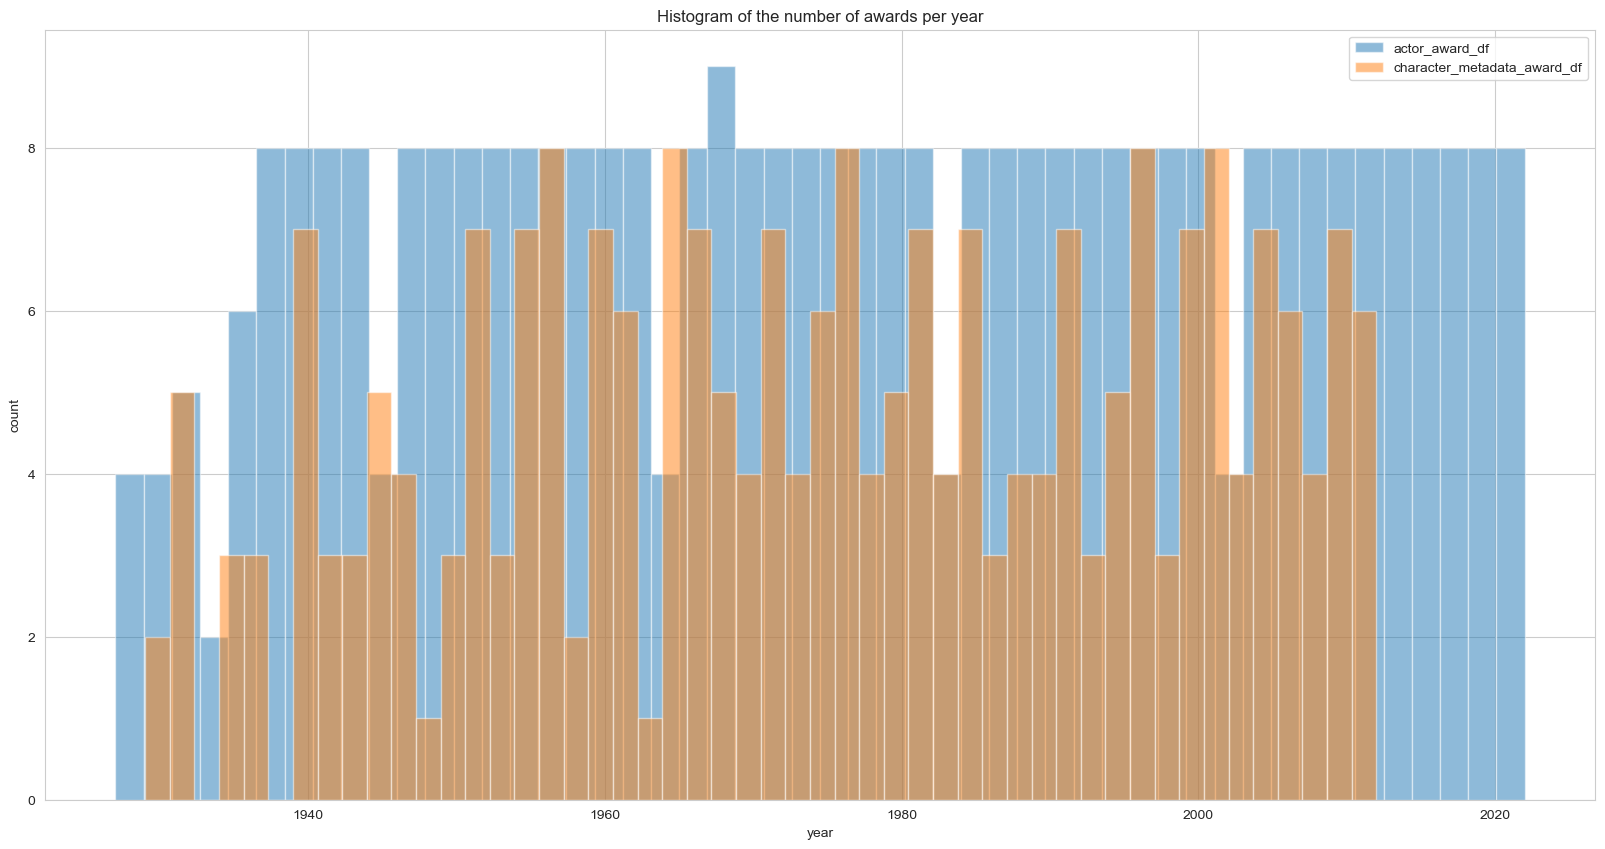

In [207]:
# histogram the number of awards per year in actor_award_df and character_metadata_award_df
plt.figure(figsize=(20,10))
plt.hist(actor_award_df['year_film'], bins=50, alpha=0.5, label='actor_award_df')
plt.hist(character_metadata_award_df['year_film'], bins=50, alpha=0.5, label='character_metadata_award_df')
plt.legend(loc='upper right')
plt.title('Histogram of the number of awards per year')
plt.xlabel('year')
plt.ylabel('count')
plt.show()

In [182]:
# merge character_metadata_award_df and best_picture_df
movie_metadata_award_df = pd.merge(movie_metadata_df, best_picture_df, 
                                 how='right',
                                 left_on=['movie_name'], 
                                 right_on=['film'])

# keep only rows where either the startYear is equal to the year_film or the startYear is equal to the year_ceremony else keep the startYear is na
movie_metadata_award_df = movie_metadata_award_df[(movie_metadata_award_df['startYear'] == movie_metadata_award_df['year_film']) | 
                                                  (movie_metadata_award_df['startYear'] == movie_metadata_award_df['year_ceremony']) |
                                                  (movie_metadata_award_df['startYear'].isna())]

# extract the duplicate rows on the column 'film'
duplicateRowsDF = movie_metadata_award_df[movie_metadata_award_df.duplicated(['film'], keep=False)]

# keep only the rows where the startYear is na
duplicateRowsDF = duplicateRowsDF[duplicateRowsDF['startYear'].isna()]

# drop rows that are in both duplicateRowsDF and movie_metadata_award_df
movie_metadata_award_df = movie_metadata_award_df.drop(duplicateRowsDF.index)

print(movie_metadata_award_df.shape)
# sort by movie_release_date
movie_metadata_award_df = movie_metadata_award_df.sort_values(by=['year_film'])
movie_metadata_award_df.head(10)

(91, 16)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear,year_film,year_ceremony,ceremony,category,name,film
0,61046.0,/m/0gkm1,Wings,1927-08-12,NaN,141.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/03k9fj"": ""Adventure"", ""/m/0hj3n0w"": ""Ense...",1927.0,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,Wings
1,61182.0,/m/0glt1,The Broadway Melody,1929-02-01,3000000.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mvs"": ""Backstage Musical"", ""/m/07s9rl...",1929.0,1928,1929,2,OUTSTANDING PICTURE,Metro-Goldwyn-Mayer,The Broadway Melody
3,4592959.0,/m/0cbl95,All Quiet on the Western Front,1930-04-21,NaN,145.0,"{""/m/064_8sq"": ""French Language"", ""/m/04h9h"": ...","{""/m/09c7w0"": ""United States of America""}","{""/m/082gq"": ""War film"", ""/m/01g6gs"": ""Black-a...",1930.0,1929,1930,3,OUTSTANDING PRODUCTION,Universal,All Quiet on the Western Front
5,2410609.0,/m/07b506,Cimarron,1931-02-09,1383000.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hfjk"":...",1931.0,1930,1931,4,OUTSTANDING PRODUCTION,RKO Radio,Cimarron
6,44752.0,/m/0c5wn,Grand Hotel,1932-04-12,2250000.0,112.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0hj3n0w"": ""E...",1932.0,1931,1932,5,OUTSTANDING PRODUCTION,Metro-Goldwyn-Mayer,Grand Hotel
8,3947300.0,/m/0b8388,Cavalcade,1933-01-05,3500000.0,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/04t36"": ""Musical"",...",1933.0,1932,1933,6,OUTSTANDING PRODUCTION,Fox,Cavalcade
9,44696.0,/m/0c5dd,It Happened One Night,1934-02-22,2500000.0,65.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/04228s"": ""...",1934.0,1934,1935,7,OUTSTANDING PRODUCTION,Columbia,It Happened One Night
11,3992212.0,/m/0bbgly,Mutiny on the Bounty,NaT,4460000.0,132.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l...",NaN,1935,1936,8,OUTSTANDING PRODUCTION,Metro-Goldwyn-Mayer,Mutiny on the Bounty
12,44437.0,/m/0c3hq,The Great Ziegfeld,1936-04-08,NaN,186.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/0hj3mvs"": ""Backs...",1936.0,1936,1937,9,OUTSTANDING PRODUCTION,Metro-Goldwyn-Mayer,The Great Ziegfeld
13,44210.0,/m/0c1l7,The Life of Emile Zola,NaT,NaN,116.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/01g6gs"": ""Black-...",NaN,1937,1938,10,OUTSTANDING PRODUCTION,Warner Bros.,The Life of Emile Zola


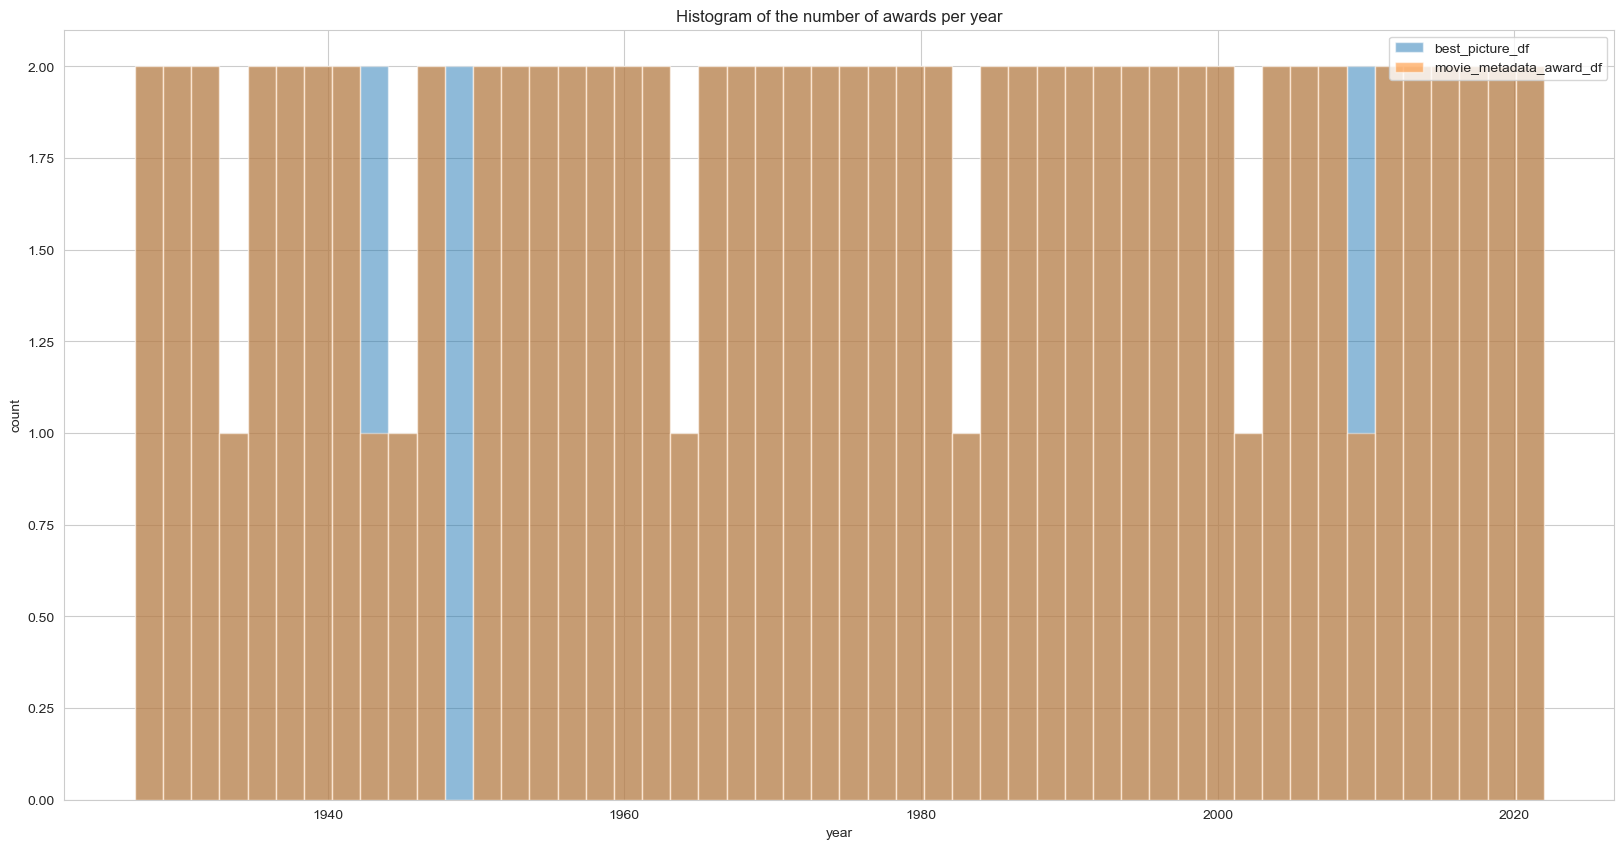

In [208]:
# histogram the number of awards per year in best_picture_df and movie_metadata_award_df
plt.figure(figsize=(20,10))
plt.hist(best_picture_df['year_film'], bins=50, alpha=0.5, label='best_picture_df')
plt.hist(movie_metadata_award_df['year_film'], bins=50, alpha=0.5, label='movie_metadata_award_df')
plt.legend(loc='upper right')
plt.title('Histogram of the number of awards per year')
plt.xlabel('year')
plt.ylabel('count')
plt.show()